# Dataset Download

In [1]:
!pip install gdown

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1-2zT-_bKjN2o2QxwSviFwbCzcWE2PnkJ'

output = 'dataset.zip'
gdown.download(url, output, quiet=False)
!unzip -q dataset.zip

# Packages

In [3]:
import os
import numpy as np
import seaborn as sns
# import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import io
from skimage.color import rgb2gray
import torch
# import random
import pandas as pd
import random
# import glob
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from IPython.display import display

# Config

In [4]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load and Process Data

##### This dataset contains brain MRI images and manual FLAIR abnormality segmentation masks, where each pixel value of masks indicates the presence or absence of cancer (0 and 1, respectively). The images correspond to 110 patients whose IDs are available in the patient_ids.csv file.


In [6]:
data = pd.read_csv('patient_ids.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      110 non-null    object
dtypes: object(1)
memory usage: 1008.0+ bytes


In [7]:
data.iloc[0]

id    TCGA_CS_4941
Name: 0, dtype: object

In [8]:
data.head()

,id
0,TCGA_CS_4941
1,TCGA_CS_4942
2,TCGA_CS_4943
3,TCGA_CS_4944
4,TCGA_CS_5393



###

##### Creating DataFrame from the downloaded dataset. New DataFrame contains these columns "patient_id", "image_path", and "mask_path".

In [9]:
temp = []
for root, dirs, files in os.walk('./mri_scans/', topdown=True):
  dirs.sort()
  if files:
    id = '_'.join(root.split('/')[-1].split('_')[:-1])
    for f in files:
      f_name = f.split('.')[0]
      if not f_name.endswith('mask'):
        image_path = os.path.join(root, f)
        mask = '_'.join([f_name, 'mask'])
        assert '.'.join([mask, 'tif']) in files
        mask_path = os.path.join(root, '.'.join([mask, 'tif']))
        temp.append([id, image_path, mask_path])

In [10]:
mri_df = pd.DataFrame(temp, columns=['patient_id', 'image_path', 'mask_path'])
assert len(mri_df) == 3929
mri_df.sort_values(['patient_id', 'image_path'], inplace=True)
mri_df.reset_index(drop=True, inplace=True)
mri_df.head()

,patient_id,image_path,mask_path
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
1,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
2,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
3,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...
4,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...



###

##### Appending has_cancer label to the corresponding record.

In [11]:
def is_cancerous(mask_path):
  mask = cv.imread(mask_path)
  if 255 in mask:
    return 1
  return 0

mri_df['has_cancer'] = mri_df['mask_path'].apply(lambda x: is_cancerous(x))
mri_df = mri_df.astype('string')
mri_df.head()

,patient_id,image_path,mask_path,has_cancer
0,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0
1,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,0
2,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,1
3,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,1
4,TCGA_CS_4941,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,./mri_scans/TCGA_CS_4941_19960909/TCGA_CS_4941...,1


# Exploratory Data Analysis


###

##### The number of images exhibiting the presence and absence of cancer.

In [12]:
presence = sum(mri_df['has_cancer'].astype('int'))
absence = len(mri_df['has_cancer']) - presence
print('Cancerous:', presence)
print('Non-cancerous:', absence)

Cancerous: 1373
Non-cancerous: 2556



###

##### The proportion of pixels designated as cancerous in relation to the total pixel count. First for all MRI images and subsequently for images displaying signs of cancer.

In [13]:
total_pixels_count = 256 * 256 * 3 * 3929
cancerous_pixels_count = sum([int(cv.imread(m).sum() / 255) for m in mri_df[mri_df['has_cancer'] == '1']['mask_path']])
print(f'The proportaion of cancerous pixels = {100 * cancerous_pixels_count / total_pixels_count}%')
print(f'The proportaion of non-cancerous pixels = {100 * (total_pixels_count - cancerous_pixels_count) / total_pixels_count}%')

The proportaion of cancerous pixels = 1.0298824334575434%
The proportaion of non-cancerous pixels = 98.97011756654246%


# Visualization

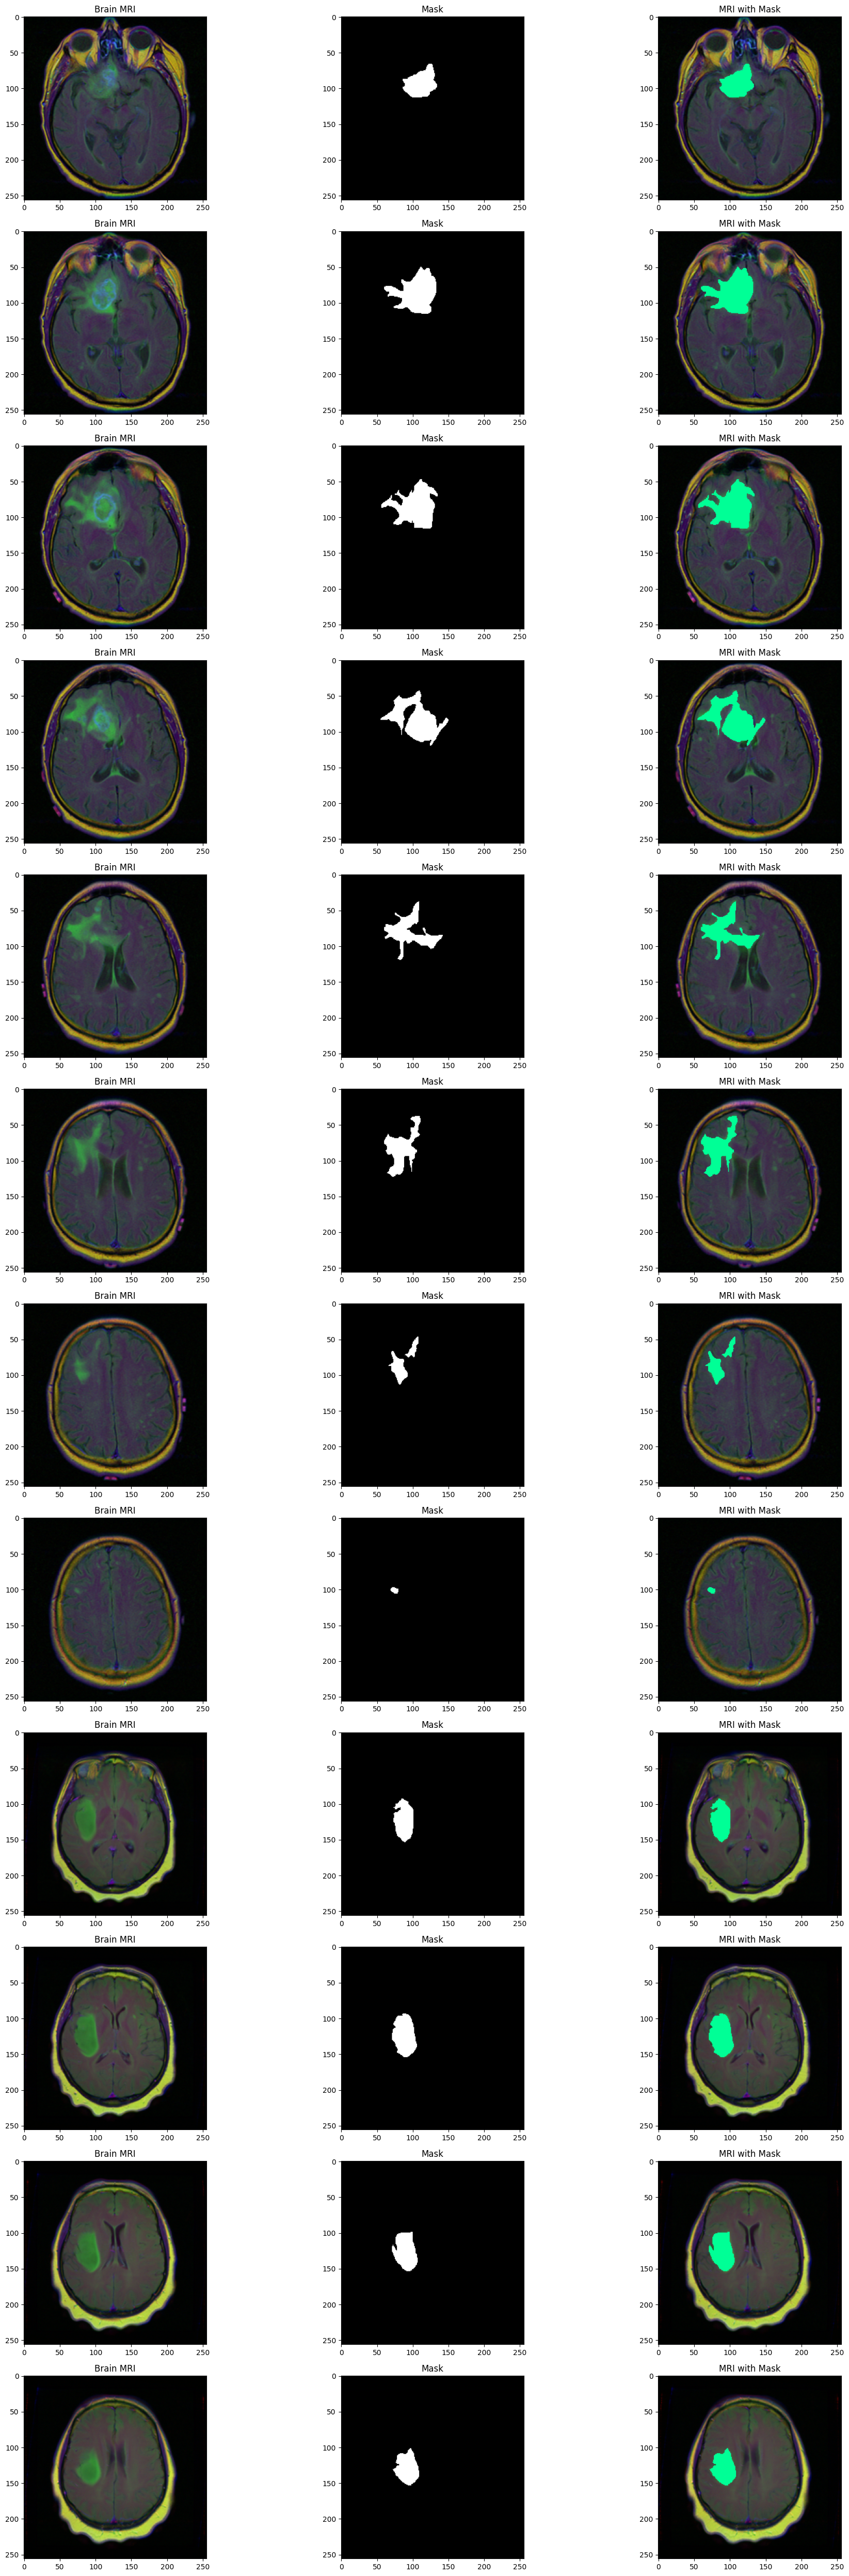

In [14]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for has_cancer in mri_df['has_cancer']:

    if (has_cancer=='1'):
        img = io.imread(mri_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(mri_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        img[mask==255] = (0,255,150)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

# Dataset & DataLoader

#### Train/Test/Val split.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

mri_df['has_cancer'] = mri_df['has_cancer'].apply(lambda x: str(x))

x_train, x_test, y_train, y_test = train_test_split(
    mri_df['image_path'],
    mri_df['has_cancer'],
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify = mri_df['has_cancer'],
)
train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)

x_train, x_val, y_train, y_val = train_test_split(
    train_df[['image_path']],
    train_df[['has_cancer']],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify = train_df['has_cancer']
)

train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)

print(f'train df count: {len(train_df)}')
print(f'test df count: {len(test_df)}')
print(f'validation df count: {len(val_df)}')

train df count: 2828
test df count: 393
validation df count: 708


In [16]:
print(train_df['has_cancer'].value_counts())
print(val_df['has_cancer'].value_counts())
print(test_df['has_cancer'].value_counts())

0    1839
1     989
Name: has_cancer, dtype: int64
0    461
1    247
Name: has_cancer, dtype: int64
0    256
1    137
Name: has_cancer, dtype: int64


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

class BrainMRIDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.length = dataframe.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = self.dataframe['image_path'][idx]
        image = Image.open(image)
        if self.image_transform:
          image = self.image_transform(image)

        has_cancer = torch.as_tensor(int(self.dataframe['has_cancer'][idx]), dtype=torch.float)
        return image, has_cancer


BATCH_SIZE = 16

train_transform = T.Compose([
    T.Grayscale(),
    T.Resize((224,224)),
    T.RandomHorizontalFlip(p=0.2),
    T.RandomVerticalFlip(p=0.1),
    T.ToTensor()
])

test_transform = T.Compose([
    T.Grayscale(),
    T.Resize((224,224)),
    T.ToTensor()
])

train_dataset = BrainMRIDataset(
    train_df,
    image_transform=train_transform,
)
val_dataest = BrainMRIDataset(
    val_df,
    image_transform=test_transform,
)
test_dataset = BrainMRIDataset(
    test_df,
    image_transform=test_transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataest, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# **Classification**

### Network Implementation:

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv_block = nn.Sequential(nn.Conv2d(1, 32, 3),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.Conv2d(32, 64, 3),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.Conv2d(64, 128, 3),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                      )

        self.linear_block = nn.Sequential(nn.Linear(128*26*26, 2048),
                                          nn.ReLU(),
                                          nn.Dropout(0.5),
                                          nn.Linear(2048,256),
                                          nn.ReLU(),
                                          nn.Dropout(0.3),
                                          nn.Linear(256,1))

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)

        return x

model = Classifier()
model.to(device)

Classifier(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=86528, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Optimizer and Weighted Criterion


In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler

lr = 2e-3
weight = (train_df['has_cancer'].value_counts().max() / train_df['has_cancer'].value_counts()).max().round(2)
weight = 10
criterion = F.binary_cross_entropy_with_logits
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-03.


### Train Test Validation functions

In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for input, target in loader:
      input = input.to(device)
      target = target.to(device)

      weights=torch.where(target == 0, 1.0, target*weight).to(device)
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, target.reshape(-1, 1), weight=weights.reshape(-1, 1))
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
    return running_loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    sig = nn.Sigmoid()
    with torch.no_grad():
      for input, target in loader:
        input = input.to(device)
        target = target.to(device)
        weights=torch.where(target == 0, 1.0, target*weight).to(device)
        output = model(input)
        loss = criterion(output, target.reshape(-1, 1), weight=weights.reshape(-1, 1))
        running_loss = loss.item()
        pred = sig(output).round()
        running_acc += accuracy_score(target.cpu(), pred.cpu())
        running_precision += precision_score(target.cpu(), pred.cpu(), zero_division=0.0)
        running_recall += recall_score(target.cpu(), pred.cpu(), zero_division=0.0)
        running_f1 += f1_score(target.cpu(), pred.cpu(), zero_division=0.0)
    return running_loss / len(loader), running_acc / len(loader), running_precision / len(loader), running_recall / len(loader), running_f1 / len(loader)

### Training loop

In [21]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, acc, precision, recall, f1 = validate_one_epoch(model, val_dataloader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val: ACC {acc:.4f}% - "
          f"Val Precision: {precision:.4f}% - "
          f"Val: Recall {recall:.4f}% - "
          f"Val F1: {f1:.2f}%")
    scheduler.step()

Epoch [1/20] - Loss: 1.8556 - Val Loss: 0.0385 - Val: ACC 0.4042% - Val Precision: 0.3656% - Val: Recall 0.9778% - Val F1: 0.52%
Adjusting learning rate of group 0 to 1.8000e-03.
Epoch [2/20] - Loss: 1.6104 - Val Loss: 0.0105 - Val: ACC 0.6556% - Val Precision: 0.4934% - Val: Recall 0.8214% - Val F1: 0.61%
Adjusting learning rate of group 0 to 1.6200e-03.
Epoch [3/20] - Loss: 1.5579 - Val Loss: 0.0252 - Val: ACC 0.5792% - Val Precision: 0.4500% - Val: Recall 0.9516% - Val F1: 0.60%
Adjusting learning rate of group 0 to 1.4580e-03.
Epoch [4/20] - Loss: 1.5542 - Val Loss: 0.0289 - Val: ACC 0.3861% - Val Precision: 0.3602% - Val: Recall 0.9778% - Val F1: 0.52%
Adjusting learning rate of group 0 to 1.3122e-03.
Epoch [5/20] - Loss: 1.5691 - Val Loss: 0.0264 - Val: ACC 0.3583% - Val Precision: 0.3485% - Val: Recall 0.9778% - Val F1: 0.51%
Adjusting learning rate of group 0 to 1.1810e-03.
Epoch [6/20] - Loss: 1.3375 - Val Loss: 0.0165 - Val: ACC 0.5569% - Val Precision: 0.4367% - Val: Recall 

# Test

In [22]:
y_pred = []
y_true = []
model.eval()
sig = nn.Sigmoid()
with torch.no_grad():
  running_loss = 0.0
  for input, target in test_dataloader:
    input = input.to(device)
    target = target.to(device)
    output = model(input)
    loss = criterion(output, target.reshape(-1, 1))
    running_loss += loss.item()
    pred = sig(output).round()
    y_pred.append(pred.item())
    y_true.append(target.item())
  test_loss = running_loss / len(test_dataloader)

print(f"Test Loss: {test_loss:.4f}\n"
      f"F1-score: {f1_score(y_true, y_pred):.4f}")

Test Loss: 0.5860
F1-score: 0.7451



# **Report**:

##### Confusion matrix and weaknesses of model.

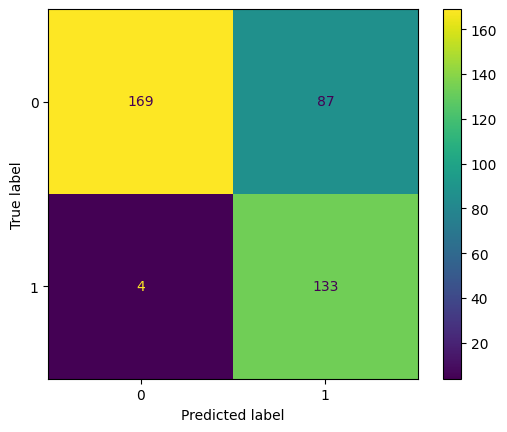

In [23]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Description:

Referring to the Confusion Matrix above, it's evident that the model has a high number of false-negatives, predicting non-cancerous when it's actually cancerous. During the training phase, the highest Precision achieved was 58.61%, even though we utilized weighted loss.


# **Feature Space Visualization**:

##### **TSNE** visualization.

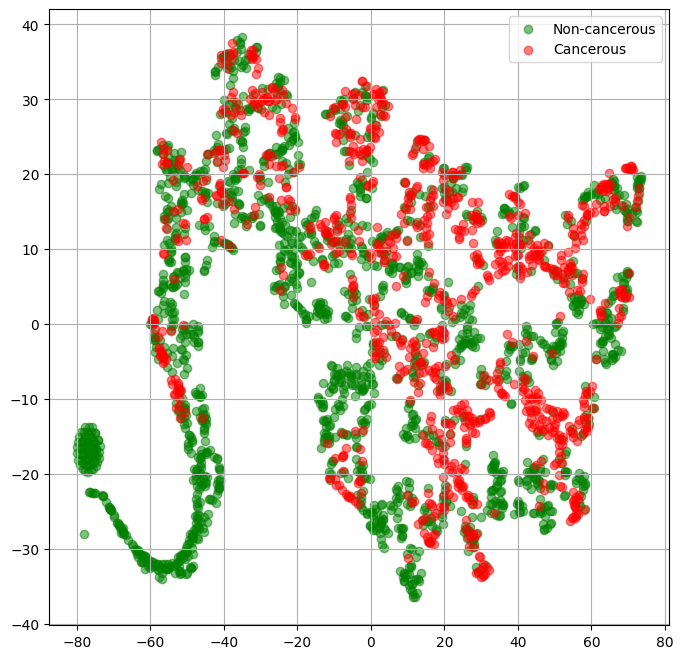

In [24]:
relu = nn.ReLU()
pooling = nn.MaxPool2d(2, 2)
conv_layers = []
model_children = list(model.children())
for i in range(len(model_children[0])):
  if type(model_children[0][i]) == nn.Conv2d:
    conv_layers.append(model_children[0][i])

images = []
for path in train_df['image_path']:
  im = Image.open(path)
  images.append(train_transform(im).to(device))

conv_feature = []
with torch.no_grad():
  for im in images:
    for i, layer in enumerate(conv_layers):
      im = pooling(relu(layer(im)))
    conv_feature.append(im)

features = []
for feature in conv_feature:
  features.append(feature.sum(dim=(1, 2)).cpu().numpy())

features = np.array(features)
data = TSNE(n_components=2).fit_transform(features)
data = pd.DataFrame(data)
data['has_cancer'] = train_df['has_cancer'].astype(int)

label_map = {0: 'Non-cancerous', 1: 'Cancerous'}
color_map = {0: 'green', 1: 'red'}
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(2):
  ax.scatter(data[data['has_cancer'] == i][0], data[data['has_cancer'] == i][1], c=color_map[i], label=label_map[i], alpha=0.5)
ax.legend()
ax.grid(True)
plt.show()